In [1]:
# Imports and Initialization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style="whitegrid")


In [3]:
# Update file paths as needed
df_sent = pd.read_csv("csvfiles/fear_greed_index.csv")
df_trader = pd.read_csv("csvfiles/historical_data.csv")


In [4]:
# Data Parsing
df_sent['date'] = pd.to_datetime(df_sent['timestamp'], unit='s')

df_trader['Timestamp IST'] = pd.to_datetime(df_trader['Timestamp IST'], dayfirst=True)

In [5]:
# Basic Data Checks
print(df_sent.info())
print(df_sent.head())

print(df_trader.info())
print(df_trader.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       2644 non-null   int64         
 1   value           2644 non-null   int64         
 2   classification  2644 non-null   object        
 3   date            2644 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 82.8+ KB
None
    timestamp  value classification                date
0  1517463000     30           Fear 2018-02-01 05:30:00
1  1517549400     15   Extreme Fear 2018-02-02 05:30:00
2  1517635800     40           Fear 2018-02-03 05:30:00
3  1517722200     24   Extreme Fear 2018-02-04 05:30:00
4  1517808600     11   Extreme Fear 2018-02-05 05:30:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  

In [6]:
# Check missing values and duplicates
print("Sentiment missing:\n", df_sent.isnull().sum())
print("Trader missing:\n", df_trader.isnull().sum())

print("Sentiment duplicates:", df_sent.duplicated().sum())
print("Trader duplicates:", df_trader.duplicated().sum())

Sentiment missing:
 timestamp         0
value             0
classification    0
date              0
dtype: int64
Trader missing:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64
Sentiment duplicates: 0
Trader duplicates: 0


In [7]:
# Drop duplicates if any
df_sent.drop_duplicates(inplace=True)
df_trader.drop_duplicates(inplace=True)

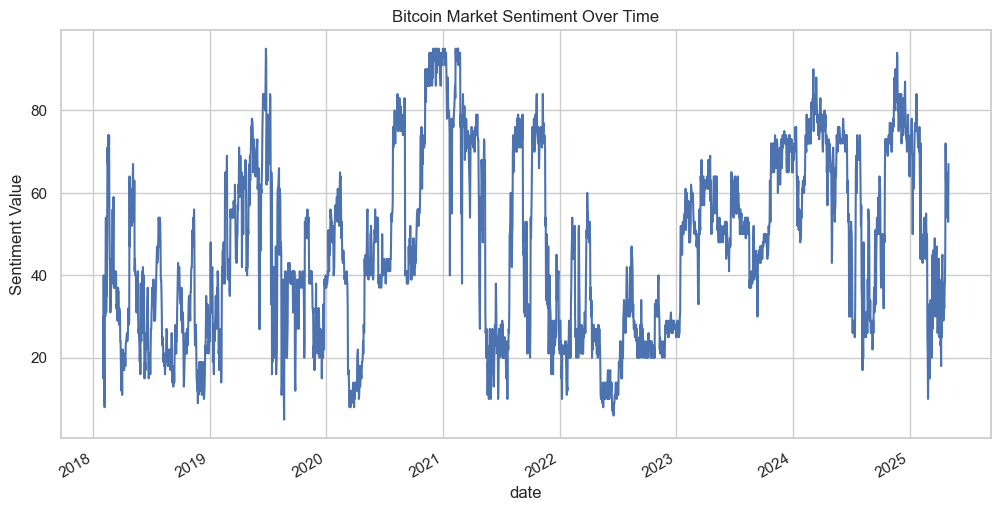

In [8]:
# Exploratory Data Analysis - Market Sentiment
plt.figure(figsize=(12,6))
df_sent.set_index('date')['value'].plot(title='Bitcoin Market Sentiment Over Time')
plt.ylabel('Sentiment Value')
plt.savefig('outputs/market_sentiment_over_time.png', bbox_inches='tight')
plt.show()

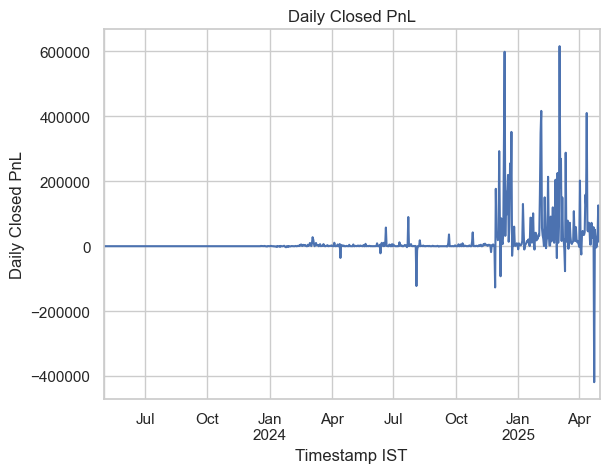

       Execution Price      Size USD     Closed PnL
count    211224.000000  2.112240e+05  211224.000000
mean      11414.723350  5.639451e+03      48.749001
std       29447.654868  3.657514e+04     919.164828
min           0.000005  0.000000e+00 -117990.104100
25%           4.854700  1.937900e+02       0.000000
50%          18.280000  5.970450e+02       0.000000
75%         101.580000  2.058960e+03       5.792797
max      109004.000000  3.921431e+06  135329.090100


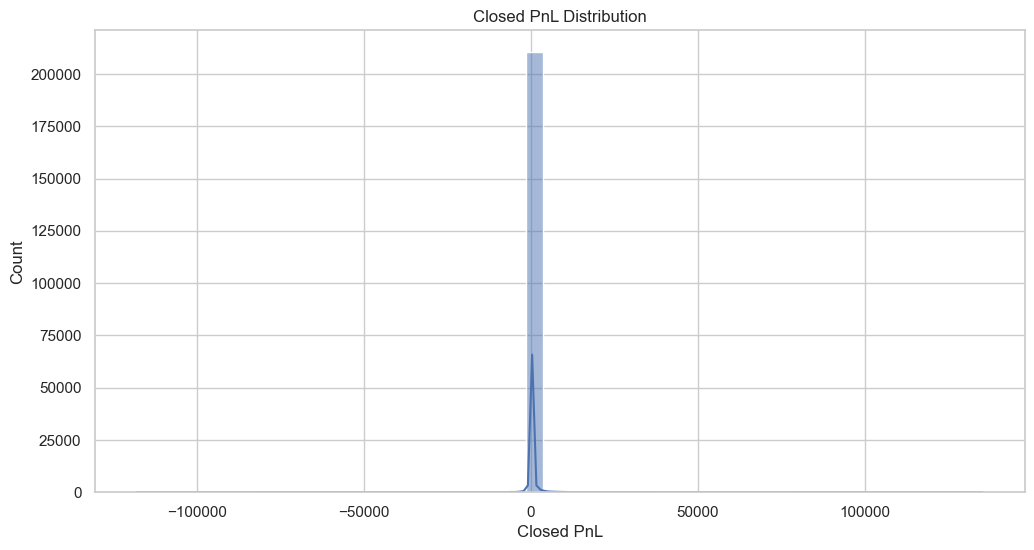

In [9]:
# Exploratory Data Analysis - Trader Data
df_trader.resample('D', on='Timestamp IST')['Closed PnL'].sum().plot(title='Daily Closed PnL')
plt.ylabel('Daily Closed PnL')
plt.savefig('outputs/daily_closed_pnl.png', bbox_inches='tight')
plt.show()

print(df_trader[['Execution Price', 'Size USD', 'Closed PnL']].describe())

plt.figure(figsize=(12,6))
sns.histplot(df_trader['Closed PnL'], bins=50, kde=True)
plt.title('Closed PnL Distribution')
plt.savefig('outputs/closed_pnl_distribution.png', bbox_inches='tight')
plt.show()

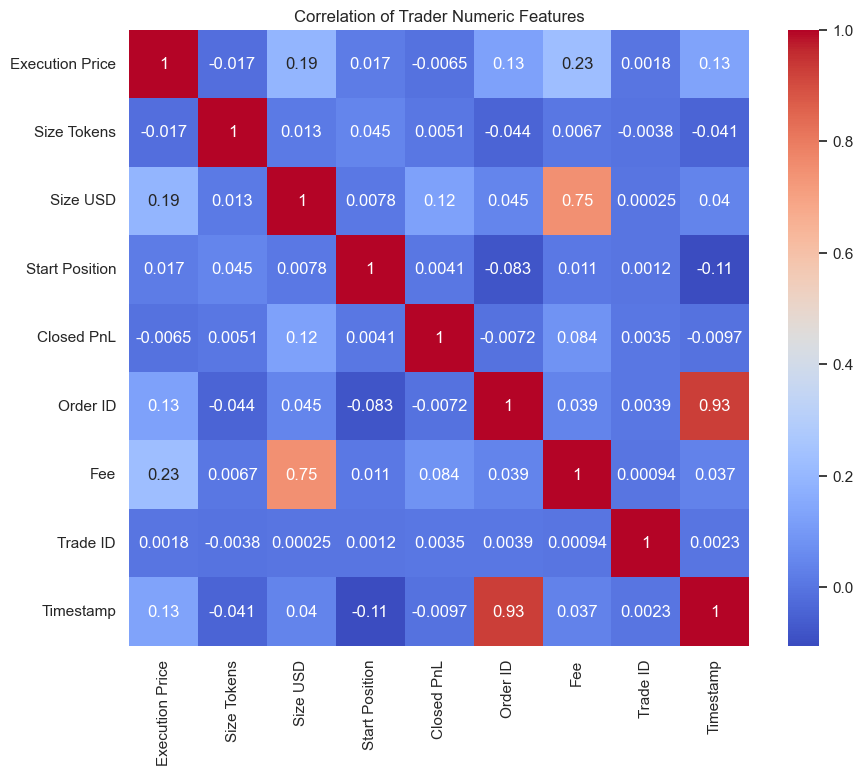

In [10]:
# Correlation Matrix for numeric columns
numeric_cols = df_trader.select_dtypes(include=['number']).columns
plt.figure(figsize=(10,8))
sns.heatmap(df_trader[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation of Trader Numeric Features')
plt.savefig('outputs/trader_features_correlation.png', bbox_inches='tight')
plt.show()

In [11]:
# Feature Engineering
df_trader['PnL_per_USD'] = df_trader['Closed PnL'] / (df_trader['Size USD'] + 1)
df_trader['Trade_Hour'] = df_trader['Timestamp IST'].dt.hour
df_trader['Profit_Flag'] = df_trader['Closed PnL'] > 0

df_trader['Tokens_per_USD'] = df_trader['Size Tokens'] / (df_trader['Size USD'] + 1)
df_trader['Trade_Type'] = df_trader['Direction'] + "_" + df_trader['Side']


Number of Outliers Detected: 854


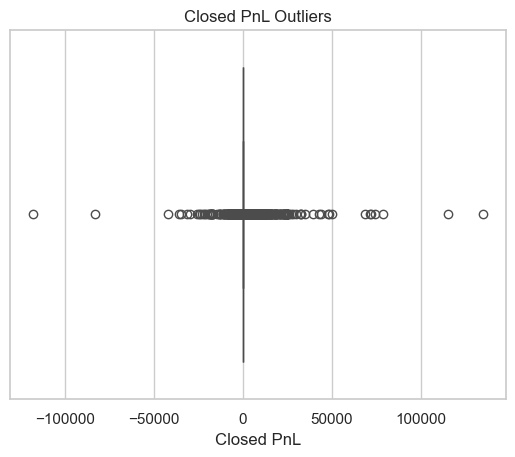

In [12]:
# Outlier Detection
df_trader['Closed_PnL_zscore'] = zscore(df_trader['Closed PnL'])
outliers = df_trader[df_trader['Closed_PnL_zscore'].abs() > 3]
print(f"Number of Outliers Detected: {outliers.shape[0]}")

sns.boxplot(x=df_trader['Closed PnL'])
plt.title('Closed PnL Outliers')
plt.savefig('outputs/closed_pnl_outliers.png', bbox_inches='tight')
plt.show()


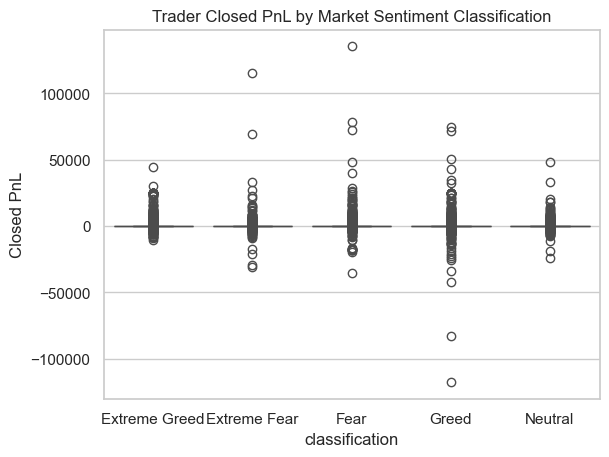

In [13]:
# Merge sentiment and trader data
df_sent['day'] = df_sent['date'].dt.date
df_trader['trade_day'] = df_trader['Timestamp IST'].dt.date
df_merged = pd.merge(df_trader, df_sent, left_on='trade_day', right_on='day', how='left')

sns.boxplot(x='classification', y='Closed PnL', data=df_merged)
plt.title('Trader Closed PnL by Market Sentiment Classification')
plt.savefig('outputs/pnl_by_sentiment.png', bbox_inches='tight')
plt.show()

In [14]:
# Prepare data for modeling
features = ['Execution Price', 'Size Tokens', 'Size USD', 'Fee', 'Trade_Hour', 'Coin', 'Side', 'Direction']
X = df_trader[features].copy()
y = df_trader['Profit_Flag']

In [15]:
# Encode categorical variables
for col in ['Coin', 'Side', 'Direction']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])


In [16]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Model training
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [19]:
# Predictions and evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.97      0.98     24802
        True       0.96      0.99      0.97     17443

    accuracy                           0.98     42245
   macro avg       0.97      0.98      0.98     42245
weighted avg       0.98      0.98      0.98     42245



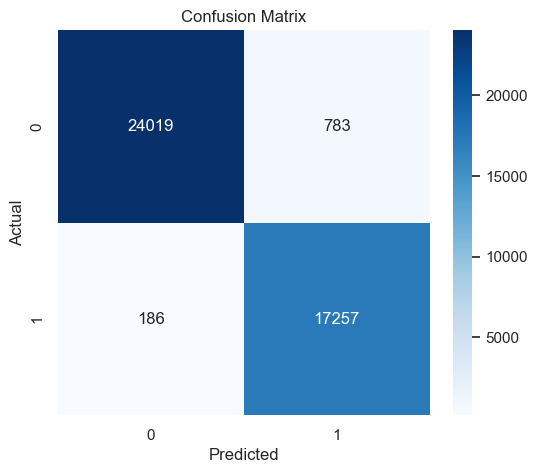

In [20]:
# Confusion Matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('outputs/confusion_matrix.png', bbox_inches='tight')
plt.show()

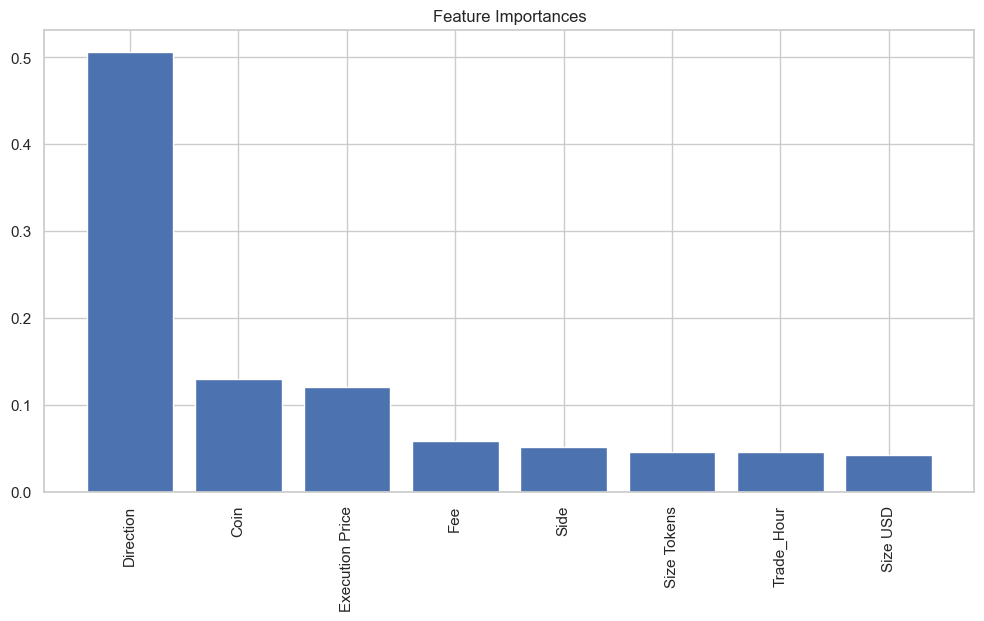

In [21]:
# Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features_names = X.columns

plt.figure(figsize=(12,6))
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), features_names[indices], rotation=90)
plt.savefig('outputs/feature_importances.png', bbox_inches='tight')
plt.show()